In [ ]:
# if you want to run the pdb debugger, run this cell
%pdb on


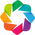

In [1]:
##### Setup/import packages
import os 
import glob
import trodes2SS
from trodes2SS import AttrDict, TrodesImport, convert_dan_posterior_to_xarray
import sungod_linearization
from sungod_linearization import createTrackGraph, hack_determinearmorder, turn_array_into_ranges, \
chunk_data, change_to_directory_make_if_nonexistent
import numpy as np
import scipy.io
import scipy as sp
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import holoviews as hv
import json
import functools
import dask
import dask.dataframe as dd
import dask.array as da
import networkx as nx
import loren_frank_data_processing as lfdp
import scipy.io as sio # for saving .mat files 
import inspect # for inspecting files (e.g. finding file source)
import multiprocessing 
import sys 
import pickle
from tempfile import TemporaryFile
from multiprocessing import Pool
import math 

path_main = '/home/anna/Src/spykshrk_realtime'
os.chdir(path_main)
from spykshrk.franklab.data_containers import FlatLinearPosition, SpikeFeatures, Posteriors, \
        EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries
from spykshrk.franklab.pp_decoder.util import normal_pdf_int_lookup, gaussian, apply_no_anim_boundary, normal2D
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPEncoder, OfflinePPDecoder
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.util import Groupby

hv.extension('matplotlib')
hv.extension('bokeh')
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)


%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['xtick.labelsize']=20
mpl.rcParams['ytick.labelsize']=20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['axes.titlesize']=26

In [2]:
# Import data

# Define path bases 
#path_base_rawdata = '/mnt/vortex/mcoulter/raw_data/'
path_base_rawdata = '/data2/mcoulter/raw_data/'

# Define parameters
# for a 45 min runtime on virga use tetrodes 4,9,11,13,15,19,21,23,25,28,30
rat_name = 'gus'
directory_temp = path_base_rawdata + rat_name + '/'
day_dictionary = {'remy':[20], 'gus':[24], 'bernard':[23], 'fievel':[19]}
epoch_dictionary = {'remy':[2], 'gus':[2], 'bernard':[2], 'fievel':[2]} 
#tetrodes_dictionary = {'remy': [4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30], # 4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30
#                       'gus': [6,7,8,9,10,11,12,17,18,19,21,24,25,26,27,30], # list(range(6,13)) + list(range(17,22)) + list(range(24,28)) + [30]
#                        'bernard': [1,2,3,4,5,7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], 
#                       'fievel': [1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,23,24,25,27,28,29]}
tetrodes_dictionary = {'remy': [4,9,11,13,15,19,21,23,25,28,30], 'gus': [6], 'bernard': [1], 'fievel': [1]}

# Maze information
os.chdir('/data2/mcoulter/maze_info/' + rat_name)
#maze_coordinates = scipy.io.loadmat('set_arm_nodes.mat',variable_names = 'linearcoord_NEW')
# new maze coordinates with only one segment for box
maze_coordinates = scipy.io.loadmat('set_arm_nodes.mat',variable_names = 'linearcoord_one_box')

datasrc = TrodesImport(directory_temp, rat_name, day_dictionary[rat_name], 
                       epoch_dictionary[rat_name], tetrodes_dictionary[rat_name])

# Import marks
marks = datasrc.import_marks()

#minimal encode settings to make import code happy 
encode_settings = AttrDict({'arm_coordinates': [[0,0]]})

# Import position (#? concerned about use of sampling rate in the definition for position)
pos = datasrc.import_pos(encode_settings, xy='x')
posY = datasrc.import_pos(encode_settings, xy='y')

# Import ripples
rips = datasrc.import_rips(pos, velthresh=4) # commented out until I get rips definition working

# Define path bases
path_base_dayepoch = 'day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0])
path_base_analysis = '/data2/mcoulter/maze_info/'


duplicates found & removed: 0


In [3]:
#filter ripples for velocity < 4
#re-shape ripples input table into format for get_irregular_resample
rips['timestamp'] = rips['starttime']
rips['time'] = rips['starttime']
rips.timestamp = rips.timestamp*30000
rips['timestamp'] = rips['timestamp'].astype(int)
rips.reset_index(level=['event'], inplace=True)
rips.columns = ['event','starttime','endtime','maxthresh','timestamp','time']
rips.set_index(['timestamp', 'time'], drop=True, append=True, inplace=True)

#filter for velocity < 4 with get_irregular_resample
linflat_obj = pos.get_mapped_single_axis()
linflat_ripindex = linflat_obj.get_irregular_resampled(rips)
linflat_ripindex_encode_velthresh = linflat_ripindex.query('linvel_flat < 4')

#re-shape to RippleTimes format for plotting
rips_vel_filt = rips.loc[linflat_ripindex_encode_velthresh.index]
rips_vel_filt.reset_index(level=['timestamp','time'], inplace=True)
rips_vel_filt.set_index(['event'], drop=True, append=True, inplace=True)
rips_vel_filtered = RippleTimes.create_default(rips_vel_filt, 1)

print('rips less than velocity 4: '+str(linflat_ripindex_encode_velthresh.shape[0]))

rips less than velocity 4: 856


In [4]:
%%time
# linearize the whole epoch - this gets rid of the pos_subset variables and linearizes position of whole epoch

encode_settings = AttrDict({'arm_coordinates': [[0,0]]})
# variables for all position data
pos_all_linear = datasrc.import_pos(encode_settings, xy='x')
posY1 = datasrc.import_pos(encode_settings, xy='y')
speed_threshold_save = 0;

#linear_start = pos.index.get_level_values('time')[subset_start]
#linear_end = pos.index.get_level_values('time')[subset_end]

# Define path base
#path_base_timewindow = str(int(round(linear_start))) + 'to' + str(int(round(linear_end))) + 'sec'
path_base_timewindow = 'whole_epoch_v3'
path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

# Change to directory with saved linearization result
# Define folder for saved linearization result 
linearization_output_save_path = path_base_foranalysisofonesessionepoch + '/linearization_output/'
linearization_output_save_path
# Check if it exists, make if it doesn't
directory_path = linearization_output_save_path
change_to_directory_make_if_nonexistent(directory_path)

# Define name of linearization result
linearization_output1_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_linear_distance_arm_shift' + '.npy'
linearization_output2_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_track_segment_id_use' + '.npy'
# If linearization exists
print('Linearization result exists. Loading it.')
linear_distance_arm_shift = np.load(linearization_output1_save_filename)
#test = np.load(linearization_output3_save_filename)
track_segment_id_use = np.load(linearization_output2_save_filename)
#pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
#for whole epoch 
pos_all_linear['linpos_flat'] = linear_distance_arm_shift

Linearization result exists. Loading it.
CPU times: user 460 ms, sys: 48 ms, total: 508 ms
Wall time: 746 ms


In [5]:
# LINEARIZATION POST-PROCESSING NEW

track_segments = np.unique(track_segment_id_use)
seg_pos_range = []
seg_pos_range_edges = [] 
for seg in track_segments:
    seg_inds = track_segment_id_use==seg      #get index of positions on that segment
    seg_pos = pos_all_linear.values[seg_inds,0]    # store those positions
    seg_pos_range.append([seg_pos.min() ,seg_pos.max()])    # get min and max vals per segment
    seg_pos_range_edges.append([np.floor(seg_pos.min()), np.ceil(seg_pos.max())])

edgeswewant_tmp = []
for seg_range in np.floor(seg_pos_range_edges): # for each track segment
    edgeswewant_tmp.append(np.arange(seg_range[0],seg_range[1]+1)) # + 1 to account for np.arange not including last index

edgeswewant = np.unique(np.concatenate(edgeswewant_tmp))   # concatenate and get rid of duplicate bins from box segs
arm_coordinates = np.column_stack(turn_array_into_ranges(edgeswewant))   # use eric's tool to get start & end of each region


In [6]:
# BINNING 
# note that these pos bins are for binning the cm data, distinct from encoder.pos_bins (which are actually indexes)
pos_bin_size = 5
armcoordinates_binned = []
pos_bins = []
for arm in np.arange(0,arm_coordinates.shape[0],1):
    arm_bounds = arm_coordinates[arm]
    # add to arm edge value to make it divisible by posbin. each arm starts at the node, and now will end some 5cm bins later
    remainder = np.mod((arm_bounds[1]-arm_bounds[0]),pos_bin_size)   
    if remainder: 
        extra_needed = pos_bin_size-remainder     
    else:
        extra_needed = 0
    new_bounds = [arm_bounds[0], arm_bounds[1]+extra_needed]
    armcoordinates_binned.append(new_bounds)
    # construct pos bin edges. this is not just a range, because the gaps are not strictly 5cm (thanks to the adjustments above)
    pos_bins.append(np.arange(new_bounds[0],new_bounds[1]+1,5))   
    if arm_bounds[1] < arm_coordinates[-1,-1]:  
        pos_bins.append(np.arange(new_bounds[1],arm_coordinates[arm+1][0]+1,pos_bin_size))  # add gap bins
        
# there are lots of repeat bins in segments in the box - get rid of them         
pos_bins = np.unique(np.concatenate(pos_bins))  # analog to mike's position_bins
print(pos_bins)

armcoords_inds = []     # find the indexes of the arm ends (mike's new_arm_coords)
for end in armcoordinates_binned:
    startind=np.where(pos_bins == end[0])
    endind = np.where(pos_bins == end[1])
    armcoords_inds.append([startind[0][0],endind[0][0]-1])
armcoords_inds = np.array(armcoords_inds)

# hard code end of arm 7 -> gap and end of arm 8
#armcoords_inds[7,1] = 127
#armcoords_inds[8,1] = 144
print(armcoords_inds)

# bin linearized position data with these bins
# digitize returns the bin index for each value, converting position measure into binindex measure (1-based)
digitized = np.digitize(pos_all_linear['linpos_flat'], pos_bins)
pos_all_linear['linpos_flat'] = digitized
pos_all_linear['linpos_flat'] = pos_all_linear['linpos_flat'] - 1   # -1 for python 0-based



[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 689. 694. 699. 704. 709. 714.]
[[  0   8]
 [ 13  25]
 [ 30  43]
 [ 47  60]
 [ 65  77]
 [ 82  94]
 [ 99 111]
 [116 128]
 [133 145]]


In [7]:
# determine what proportion of the bin is used for pos_bin_delta
# only define this for arm end bins, because everything else should be complete
pos_delta = np.ones(armcoords_inds[-1][-1]+1)
for i in np.arange(0,len(pos_bins),1):  #iterate through pos bins (excludes box end)
    if i in armcoords_inds[1:,1]:     # calc coverage if this is an arm end bin
        pos_in_bin = linear_distance_arm_shift[(linear_distance_arm_shift>pos_bins[i]) & (linear_distance_arm_shift<pos_bins[i+1])]        
        #if pos_in_bin.size > 0:
        pos_delta[i] = (max(pos_in_bin)-pos_bins[i])/pos_bin_size

pos_delta = 1/pos_delta   # take inverse since we end up dividing by this and we'd rather multiply


In [8]:
    #define encoding settings

# this is 1 bin past the end of the position bins
#max_pos = new_arm_coords[-1][1] + 1
max_pos = armcoords_inds[-1][-1]+1

encode_settings = AttrDict({'sampling_rate': 3e4,
                                'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                                'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                                'pos_bin_delta': pos_delta, 
                                # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                                'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 1), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1),    
                                'pos_kernel_std': 1, 
                                'mark_kernel_std': int(20), 
                                'pos_num_bins': max_pos, # len(arm_coords_wewant)
                                'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # or range(0,max_pos,10)
                                'arm_coordinates': armcoords_inds ,   #new_arm_coords
                                'spk_amp': 60,
                                'vel': 0}) 

#print('Encode settings: ',encode_settings)

    #cell 9
    #define decode settings
decode_settings = AttrDict({'trans_smooth_std': 2,
                                'trans_uniform_gain': 0.0001,
                                'time_bin_size':60})

#print('Decode settings: ',decode_settings)


In [11]:
    #cell 9.1 randomize trial order within epoch
    #read in trial times
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)
trialsindex = np.arange(starttimes.shape[0])
print('Number of trials: ',trialsindex.shape)

    # randomize trial order
indices = np.arange(starttimes.shape[0])
np.random.shuffle(indices)

    #fixed random order
    # specific to remy day 20 epoch 2
#indices = [ 17,  92,   3,  98,  11,  78, 105, 100, 103,  37,  28,  62,  85,  59,  41,  93,  29, 102, 
#6,  76,  13,  82,  18,  25,  64,  96,  20,  16,  65,  54,  12,  24,  56,   5,  74,  73, 
#79,  89,  97,  70,  68,  46,   7,  40, 101,  48,  77,  63,  69, 108,  66,  15,  91,  33, 
#45,  21,  51,  19,  30,  23,  72,  35,  42,  47,  95, 107, 104,  61,  43,  60,  67,  88, 
#71,  14,  38,  32,  87,  57,  27,  31,   1,   2,  53,  86,  50,  49,   0,  52,  90,  10, 
#44,  84,  55,  81, 106,  39,  75,  58,   9,  34,   4,   8,  26,  22,  94,  83,  36,  80, 99]

starttimes_shuffled = starttimes[indices]
endtimes_shuffled = endtimes[indices]
trialsindex_shuffled = trialsindex[indices]
#print('Randomized trial order: ',trialsindex_shuffled)


Number of trials:  (106,)


In [12]:
#to make a new position, marks and trial file with new start and end times:
    #position
random_trial_pos_all = pos_all_linear.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)
         
    #marks
random_trial_marks_all = marks.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes_shuffled[i]) & (marks.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_marks_all = random_trial_marks_all.append(random_trial_marks)

    # filter for large negative marks and spike amplitude
marks_random_trial_non_negative = trodes2SS.threshold_marks_negative(random_trial_marks_all, negthresh=-999)
print('Original encode length: ',random_trial_marks_all.shape)
print('Encoding marks non-negative filter: ',marks_random_trial_non_negative.shape)

# filter for mark amplitude - can increace min to reduce # of spikes
random_trial_spk_subset_sparse = trodes2SS.threshold_marks(marks_random_trial_non_negative, 
                                                           maxthresh=2000,minthresh=100)
print('original length: '+str(marks_random_trial_non_negative.shape[0]))
print('after filtering: '+str(random_trial_spk_subset_sparse.shape[0]))

    # velocity filter to define encoding and decoding times
velocity_filter = 4
print('Velocity filter: ',velocity_filter)

    # #encoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > @velocity_filter')
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

    # re-order encoding spikes after get_irregular_resample to match random trial order with position


encode_spikes_random_trial_random = encode_spikes_random_trial.head(0)
for i in range(len(starttimes_shuffled)):
    encode_random_spikes = encode_spikes_random_trial.loc[(encode_spikes_random_trial.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_random_trial.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_spikes_random_trial_random = encode_spikes_random_trial_random.append(encode_random_spikes)

print('encoding spikes after velocity filter: '+str(encode_spikes_random_trial.shape[0]))

    # #decoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_decode_velthresh = linflat_spkindex.query('linvel_flat < @velocity_filter')

decode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_decode_velthresh.index]

print('decoding spikes after velocity filter: '+str(decode_spikes_random_trial.shape[0]))

    #filter position for velocity
random_trial_pos_all_vel = random_trial_pos_all.loc[(random_trial_pos_all['linvel_flat']>velocity_filter)]
    #random_trial_pos_all_vel = pos_all_linear.loc[(pos_all_linear['linvel_flat']>velocity_filter)]


0 below -999uV events removed
Original encode length:  (409102, 4)
Encoding marks non-negative filter:  (409102, 4)
0 above 2000uV events removed
0 below 100uV events removed
original length: 409102
after filtering: 409102
Velocity filter:  4
encoding spikes after velocity filter: 189723
decoding spikes after velocity filter: 219381


In [13]:
#cell 9.2 shift encoding marks by set amount of time

    # caclulate epoch min and max times - need to do this on pre-filter marks
marks_for_epoch_time = marks.reset_index(level='time')
min_time = marks_for_epoch_time['time'].iloc[0]
max_time = marks_for_epoch_time['time'].iloc[-1]
epoch_time = max_time - min_time
print('Total epoch time (sec): ',epoch_time)

    # # shift by 25% of the epoch time
    # note shift_amt is defined above in the outer loop
    # marks_index_shift converts shift_amt to a specific index in the marks dataframe
shift_amt = 0
marks_index_target = min_time + shift_amt*epoch_time
encode_spikes_shift_query = encode_spikes_random_trial.reset_index()
marks_index_shift = encode_spikes_shift_query.iloc[(encode_spikes_shift_query['time']-marks_index_target).abs().argsort()[:1]].index.item()
    #marks_index_shift = 0

print('Marks index shift: ',marks_index_shift)

    # format table to compare original and shifted marks
    #encode_spikes_random_trial_save = encode_spikes_random_trial_random
    #encode_spikes_random_trial_save = encode_spikes_random_trial
    #encode_spikes_random_trial_save['c00_shift'] = np.roll(encode_spikes_random_trial_save['c00'],-(marks_index_shift))
    #encode_spikes_random_trial_save['c01_shift'] = np.roll(encode_spikes_random_trial_save['c01'],-(marks_index_shift))
    #encode_spikes_random_trial_save['c02_shift'] = np.roll(encode_spikes_random_trial_save['c02'],-(marks_index_shift))
    #encode_spikes_random_trial_save['c03_shift'] = np.roll(encode_spikes_random_trial_save['c03'],-(marks_index_shift)) 

 
    # apply shift to tetrode channel columns in original dataframe
encode_spikes_random_trial = []
encode_spikes_random_trial_random = []
encode_random_spikes = []
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]
encode_spikes_random_trial_random = encode_spikes_random_trial.head(0)
for i in range(len(starttimes_shuffled)):
    encode_random_spikes = encode_spikes_random_trial.loc[(encode_spikes_random_trial.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_random_trial.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_spikes_random_trial_random = encode_spikes_random_trial_random.append(encode_random_spikes)

encode_spikes_random_trial_random['c00'] = np.roll(encode_spikes_random_trial_random['c00'],-(marks_index_shift))
encode_spikes_random_trial_random['c01'] = np.roll(encode_spikes_random_trial_random['c01'],-(marks_index_shift))
encode_spikes_random_trial_random['c02'] = np.roll(encode_spikes_random_trial_random['c02'],-(marks_index_shift))
encode_spikes_random_trial_random['c03'] = np.roll(encode_spikes_random_trial_random['c03'],-(marks_index_shift))  
    
    # use velocity filter to put marks back in chronological order
encode_spikes_random_trial_chron = encode_spikes_random_trial_random.loc[linflat_spkindex_encode_velthresh.index]

print('Shifted marks shape: ', encode_spikes_random_trial_chron.shape)


Total epoch time (sec):  3659.9521999999997
Marks index shift:  0
Shifted marks shape:  (189723, 4)


In [14]:
%%time
# run encoder
print('Starting encoder')

    #for whole epoch: linflat=pos_all_linear_vel
    #for subset: linflat=pos_subset
encoder = OfflinePPEncoder(linflat=random_trial_pos_all_vel, dec_spk_amp=decode_spikes_random_trial, encode_settings=encode_settings, 
                               decode_settings=decode_settings, enc_spk_amp=encode_spikes_random_trial_chron, dask_worker_memory=1e9,
                               dask_chunksize = None)

    #new output format from encoder: observ_obj
observ_obj = encoder.run_encoder()

#save transition matrix
#trans_mat_pandas = pd.DataFrame(data=trans_mat,index=np.arange(0,144),columns=np.arange(0,144))
#trans_mat_pandas.to_csv('/p/lustre1/coulter5/remy/trans_mat_uniform_5_29_19.csv')


18:42:58 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 329
18:42:58 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 50.0%
18:42:58 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 476.22 MB


Starting encoder


/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:259: RuntimeWarning:
invalid value encountered in true_divide
/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:275: RuntimeWarning:
invalid value encountered in true_divide
/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:282: RuntimeWarning:
invalid value encountered in true_divide
/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:315: RuntimeWarning:
invalid value encountered in true_divide
/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:319: RuntimeWarning:
invalid value encountered in true_divide
/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:346: RuntimeWarning:
invalid value encountered in true_divide
/home/anna/Src/spykshrk_realtime/spykshrk/franklab/pp_decoder/pp_clusterless.py:394: RuntimeWarning:
invalid value encountered in true_divide
INFO:r

CPU times: user 2h 48min 24s, sys: 3h 52min 13s, total: 6h 40min 37s
Wall time: 10min 10s


In [15]:
%%time

print('Starting decoder')
# normally: trans_mat=encoder.trans_mat['flat_powered']
decoder = OfflinePPDecoder(observ_obj=observ_obj, trans_mat=encoder.trans_mat['sungod'], 
                               prob_no_spike=encoder.prob_no_spike,
                               encode_settings=encode_settings, decode_settings=decode_settings, 
                               time_bin_size=decode_settings.time_bin_size, all_linear_position=pos_all_linear, velocity_filter=4)

posteriors = decoder.run_decoder()
print('Decoder finished!')
print('Posteriors shape: '+ str(posteriors.shape))
    

Starting decoder
Beginning likelihood calculation
Beginning posterior calculation
Decoder finished!
Posteriors shape: (1821667, 148)
CPU times: user 6min 35s, sys: 5min 2s, total: 11min 37s
Wall time: 4min 1s


In [ ]:
# OPTIONAL: store outputs for later comparison
beforenormobs = observ_obj
beforenormliklihoods = decoder.likelihoods
beforenormposterior = posteriors

In [16]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

# visualize posteriors - note will only work a small chunck of the posteriors table

dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], riptimes=rips_vel_filtered[50:100], enc_settings=encode_settings)

#dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)

/home/anna/anaconda3/lib/python3.5/site-packages/bokeh/core/json_encoder.py:80: FutureWarning:
Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


:DynamicMap   [time]
   :Overlay
      .RGB.I           :RGB   [time (s),linpos (cm)]   (R,G,B,A)
      .Points.Linpos   :Points   [time (s),linpos (cm)]
      .Arm_bound.I     :Curve   [x]   (y)
      .Arm_bound.II    :Curve   [x]   (y)
      .Arm_bound.III   :Curve   [x]   (y)
      .Arm_bound.IV    :Curve   [x]   (y)
      .Arm_bound.V     :Curve   [x]   (y)
      .Arm_bound.VI    :Curve   [x]   (y)
      .Arm_bound.VII   :Curve   [x]   (y)
      .Arm_bound.VIII  :Curve   [x]   (y)
      .Arm_bound.IX    :Curve   [x]   (y)
      .Arm_bound.X     :Curve   [x]   (y)
      .Arm_bound.XI    :Curve   [x]   (y)
      .Arm_bound.XII   :Curve   [x]   (y)
      .Arm_bound.XIII  :Curve   [x]   (y)
      .Arm_bound.XIV   :Curve   [x]   (y)
      .Arm_bound.XV    :Curve   [x]   (y)
      .Arm_bound.XVI   :Curve   [x]   (y)
      .Arm_bound.XVII  :Curve   [x]   (y)
      .Arm_bound.XVIII :Curve   [x]   (y)
      .Events.Ripples  :Polygons   [x,y]

In [ ]:
# OPTIONAL: save posteriors and position
posterior_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_shuffle_' + str(marks_index_shift) + '_posteriors_6_17_19.nc'

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = convert_dan_posterior_to_xarray(post2, tetrodes_dictionary[rat_name], 
                                        velocity_filter, encode_settings, decode_settings, encoder.trans_mat['sungod'], trialsindex_shuffled, marks_index_shift)
    #print(len(post3))
post3.to_netcdf(posterior_file_name)
print('Saved posteriors to '+posterior_file_name)

    # to export linearized position to MatLab: again convert to xarray and then save as netcdf

position_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_shuffle_' + str(marks_index_shift) + '_linearposition_6_17_19.nc'

linearized_pos1 = pos_all_linear.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf(position_file_name)
print('Saved linearized position to '+position_file_name)
    

## VISUALIZE STUFF 

In [ ]:
%%output size=100 backend='bokeh'
%%opts Curve [aspect=4] (color='black') 

# plot binning of data into 5cm bins -- (before randomization of trial order!)

p1 = hv.Curve(pos_all_linear['linpos_flat'],'time','linpos (cm)',group='orig')
p2 = hv.Curve(5*digitized,'time','binindex',group='digitized (x5 for scale)')
layout = hv.Layout(p1 +p2).cols(2)
layout

In [ ]:
%%output backend='bokeh' size=100
%%opts Histogram {+axiswise}

# plot postition histogram, marks histogrm, and firing rate (+ FR normalization stages)

poshist, posbins = np.histogram(a=random_trial_pos_all_vel['linpos_flat'], bins=np.arange(0,147),normed=False)
hist1 = hv.Histogram(poshist,group='encode pos')
linflat_obj = random_trial_pos_all_vel.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(encode_spikes_random_trial_chron)
marks_linear = encode_spikes_random_trial_chron.assign(linear_pos=pd.Series(linflat_spkindex['linpos_flat']).values)
markshist, marksbins = np.histogram(a=marks_linear['linear_pos'], bins=np.arange(0, 147),normed=False)
hist2 = hv.Histogram(markshist,group='encode mark pos')
hist3 =hv.Histogram(encoder.occupancy,group='occupancy')
hist4 = hv.Histogram(encoder.firing_rate[4],group='encoder FR')
hist5 = hv.Histogram(encoder.firing_rate[4]/encoder.occupancy,group='occ norm FR')
hist6 = hv.Histogram(encoder.prob_no_spike[4],extents=(0, .98, 147, 1),group='pns')
layout = hv.Layout(hist1 + hist2+hist3+hist4+hist5+hist6).cols(3)    #
layout

In [ ]:
%%output backend='bokeh' size=100
%%opts Histogram {+axiswise}

# histograms of peak probability for observations, likelihoods, and posteriors 

hist_obs = []
obs_binsonly = observ_obj.drop(['elec_grp_id','position','dec_bin','dec_bin_start','num_missing_bins','parallel_bin'], axis=1)
#take axis label of max obs density, remove x prefix and cast as int to get binind
obs_maxbin = obs_binsonly.idxmax(axis=1).str.strip('x').astype(int) 
obshist,tmp = np.histogram(obs_maxbin,bins=np.arange(0,147))
h1 = hv.Histogram(obshist,group='max ind of observations')

lik_binsonly = decoder.likelihoods.drop(['num_spikes','dec_bin'], axis=1)
lik_maxbin = lik_binsonly.fillna(0).idxmax(axis=1).str.strip('x').astype(int)
lik_hist,tmp = np.histogram(lik_maxbin,bins=np.arange(0,147))
h2 = hv.Histogram(lik_hist,group='max ind of likelihoods')

post_binsonly = posteriors.drop(['num_spikes','dec_bin'], axis=1)
post_maxbin = post_binsonly.fillna(0).idxmax(axis=1).str.strip('x').astype(int)
post_hist,tmp = np.histogram(post_maxbin,bins=np.arange(0,147))
h3 = hv.Histogram(post_hist,group='max ind of posteriors')
layout = hv.Layout(h1+h2+h3)
layout

## STEP BY STEP ENCODING/DECODING

In [ ]:
%%output size=100 backend='bokeh'
%%opts Histogram {+axiswise}
%%opts Scatter {+axiswise}
%%opts Image (cmap='viridis') {+axiswise}

# STEP BY STEP ENC/DEC : get observations 
#  TO DO: add something here to visualize the mark smoothing 

# 1. get the positions corresponding to each spike time of the encoding spikes
#    smooth them with a gaussian (pos_kernel_std). plot this as histogram

tetnum = 4
singletetenc_marks = encode_spikes_random_trial_chron.loc[encode_spikes_random_trial_chron.index.get_level_values('elec_grp_id')==tetnum]
singletetenc_pos = random_trial_pos_all_vel.get_irregular_resampled(singletetenc_marks)
pos_distrib_tet = sp.stats.norm.pdf(np.expand_dims(encode_settings.pos_bins,0),np.expand_dims(singletetenc_pos['linpos_flat'],1),1)

p1 = hv.Image(np.flipud(pos_distrib_tet[1:5000:1,:].T), kdims=['spike event','pos_bins'],bounds = (0,0,5000, pos_distrib_tet.shape[1]),group='encoding model smoothed position')
spikinghist,_ = np.histogram(singletetenc_pos['linpos_flat'][:5000],bins = np.arange(0,147))
p2 = hv.Histogram(spikinghist ,group='enc poshist (occupancy;first5000)')

# 2. get the mark contrib weights, based on the distance between each decoding and encoding spike
    # combine across mark dimensions
singletetdec_marks = decode_spikes_random_trial.loc[decode_spikes_random_trial.index.get_level_values('elec_grp_id')==tetnum]
mark_contrib = normal_pdf_int_lookup(np.expand_dims(singletetdec_marks[4000:10000], 1),
                                             np.expand_dims(singletetenc_marks, 0),
                                             encode_settings.mark_kernel_std)
all_contrib = np.prod(mark_contrib, axis=2)

# 3. multiply encoding spikes by their weights to generate observations; plot
observ = np.matmul(all_contrib, pos_distrib_tet) # can handle all! [5000:15000]
p4 = hv.Image(np.flipud(observ.T), kdims=['decoding spk','pos_bins'],bounds = (0,0,4000, pos_distrib_tet.shape[1]),group='obs no norm')

# 4. normalize obs by occupancy, POS_DELTA, and within each row
newspikinghist = np.array(spikinghist).astype(float)  #make occupancy contain nans not zeros, like real one
newspikinghist[newspikinghist==0]=np.nan
normed_observ = observ / (encoder.occupancy*pos_delta)
observ_sum = np.nansum(normed_observ, axis=1)

if any(observ_sum==0): # replace all rows that are all zeros with uniform distribution 
    print('found a zero-row!?') # still don't quite understand when this occurs, but it happens 
    observ_sum_zero = observ_sum == 0
    observ[observ_sum_zero, :] = 1/(encode_settings.pos_bins[-1] - encode_settings.pos_bins[0])
    observ_sum[observ_sum_zero] = 1

newnormed_observ = normed_observ / observ_sum[:, np.newaxis]
p5 = hv.Image(np.flipud(newnormed_observ.T), kdims=['decoding spk','pos_bins'],bounds = (0,0,4000, pos_distrib_tet.shape[1]),group='obs normed')

# 5. sanity check: histogram of actual decoding spike locations
singletetdec_pos = random_trial_pos_all_vel.get_irregular_resampled(singletetdec_marks)
decspikinghist,_ = np.histogram(singletetdec_pos['linpos_flat'][:4000],bins = np.arange(0,147))
p6 = hv.Histogram(decspikinghist ,group='to check: dec occupancy first5000)')

layout = hv.Layout(p1+p2+p4+p5).cols(2)
layout


In [ ]:
%%output backend='bokeh' size=100
%%opts Scatter {+axiswise}
%%opts Curve {+axiswise}

# plot the mark weights assigned to encoding spikes (or first 500o at least) for each decoding spike one by one

def plot_observ(ind):
    markweights = np.vstack((singletetenc_pos[:5000]['linpos_flat'],all_contrib[ind,:5000]))
    p3 = hv.Scatter(markweights.T,extents=(0, 0, 145, 2e-7), group='enc spike weights for 1 decspk')
    p4 = hv.Curve(newnormed_observ[ind,:],extents=(0, 0, 145, .2),group='normalized observation')
    return hv.Layout(p3+p4)
        
dmap = hv.DynamicMap(plot_observ, kdims=['ind'])
dmap.redim.values(ind=list(range(0, 50, 1)))

## OBS -> POSTERIORS

In [ ]:
%%output backend='bokeh'
%%opts Histogram [height=300, width=400] {+axiswise} 

# plot how many spikes are in all the bins

bincounts,binedges=np.histogram(observ_obj['dec_bin'],bins=np.arange(0,observ_obj['dec_bin'].max()),normed=False)
binsummary =  np.histogram(bincounts,bins=np.arange(0,12,1),normed=False)
h1 = hv.Histogram(binsummary, group='num spikes per bin (decoding)')
h1

In [ ]:
%%output backend='bokeh' size=100
%%opts Curve [height=300, width=400] {+axiswise}

# plot the OBS -> LIKELIHOODS transformation for one decoding bin at a time

g_prob_no_spike = np.prod(list(encoder.prob_no_spike.values()), axis=0)
g_prob_no_spike = g_prob_no_spike/np.nansum(g_prob_no_spike)  # normalize

newobs = observ_obj.set_index('dec_bin')

def plot_observ(dec_bin_val):
    #liklihoods get calculated regardless of spk input
    dec_bin_lik = decoder.likelihoods[decoder.likelihoods['dec_bin'].values==dec_bin_val].drop(['num_spikes','dec_bin'],axis=1)
    h4 = hv.Curve(dec_bin_lik.values[0],extents=(0, 0, 147, 1),group='likelihood')
    # posteriors
    dec_bin_post = posteriors[posteriors['dec_bin'].values==dec_bin_val].drop(['num_spikes','dec_bin'],axis=1)
    h5 = hv.Curve(dec_bin_post.values[0],extents=(0, 0, 147, .5),group='posterior')
    obs_empty = hv.Curve(np.zeros(142),extents=(0, 0, 147, .2),group='normalized observation')  # zero line placeholder 
    pns_empty = hv.Curve(np.zeros(142),extents=(0, .95, 147, 1),group='prob no spike')  # zero line placeholder 
    plot_list1 = [obs_empty,obs_empty,obs_empty,obs_empty,obs_empty]
    plot_list2 = [pns_empty,pns_empty,pns_empty,pns_empty,pns_empty]
    if dec_bin_val in newobs.index.values:
        dec_grp = newobs.loc[dec_bin_val]
        spikers = dec_grp['elec_grp_id'].tolist()
        if isinstance(spikers,float):
            dec_grp_pos = dec_grp.drop(['elec_grp_id','position','dec_bin_start','num_missing_bins','parallel_bin'], axis=0)
            plot_list1[0] = hv.Curve(dec_grp_pos,extents=(0, 0, 145, .2),group='normalized observation')
            plot_list2[0] = hv.Curve(encoder.prob_no_spike[spikers],extents=(0, .95, 145, 1),group='prob no spike')
        else:
            dec_grp_pos = dec_grp.drop(['elec_grp_id','position','dec_bin_start','num_missing_bins','parallel_bin'], axis=1)
            
            for idx in range(0,len(spikers)):
                plot_list1[idx] = hv.Curve(dec_grp_pos.iloc[idx,:],extents=(0, 0, 145, .2),group='normalized observation')
                plot_list2[idx] = hv.Curve(encoder.prob_no_spike[spikers[idx]],extents=(0, .95, 145, 1),group='prob no spike')
        plot_list1[4] = hv.Text(70,.15,'tets: ' +str(spikers))
        both = hv.Layout(hv.Overlay(plot_list1)+hv.Overlay(plot_list2)+h4+h5).cols(2)
        return both
    else:
        plot_list2[0] = hv.Curve(g_prob_no_spike,extents=(0, .95, 145, 1),group='prob no spike')
        both = hv.Layout(hv.Overlay(plot_list1)+hv.Overlay(plot_list2)+h4+h5).cols(2)
        return both
    
dmap = hv.DynamicMap(plot_observ, kdims=['dec_bin_val'])
dmap.redim.values(dec_bin_val=list(range(0, 50, 1))) #

In [ ]:
%%output backend='bokeh' size=100
%%opts Curve [height=300, width=200] 
#%%opts Image [height=300, width=250]  {+axiswise}

# plot the LIKLIEHOODS -> POSTERIORS transofrmation  across one decoding bin at a time 

def plot_observ(dec_bin_val):
    # trans mat
    h6 = hv.Image(np.flipud(transition_mat),bounds = (0,0,142,142),group = 'trans mat')
    #last post x trans mat
    prev_post = posteriors[posteriors['dec_bin'].values==(dec_bin_val-1)].drop(['num_spikes','dec_bin'],axis=1)
    prev_post_stack = np.vstack((prev_post.values,np.arange(0,147)))
    h5 = hv.Curve(prev_post_stack.T,extents=(0, 0,.1,145),group='prev post')
    # multiply together, plot result
    prevxTM = np.matmul(transition_mat, prev_post.values[0])
    prevxTMstack = np.vstack((prevxTM,np.arange(0,142)))
    h7 = hv.Curve(prevxTMstack.T,group='pXtm')
    # plot current likelihood, multiply by newloc
    curr_lik = decoder.likelihoods[decoder.likelihoods['dec_bin'].values==dec_bin_val].drop(['num_spikes','dec_bin'],axis=1)
    curr_lik_stack = np.vstack((curr_lik.values,np.arange(0,142)))
    h4 = hv.Curve(curr_lik_stack.T,group='likelihood')
    curr_post = posteriors[posteriors['dec_bin'].values==(dec_bin_val)].drop(['num_spikes','dec_bin'],axis=1)
    curr_post_stack = np.vstack((curr_post.values,np.arange(0,142)))
    h8 = hv.Curve(curr_post_stack.T,group='post')
    both = hv.Layout(h5+h7+h4+h8).cols(5)
    return both
    
dmap = hv.DynamicMap(plot_observ, kdims=['dec_bin_val'])
dmap.redim.values(dec_bin_val=list(range(1, 50, 1))) #  can't start with zero (so can get last post)

In [ ]:
#hv.Image(encoder.trans_mat['flat_powered'],group = 'trans mat')
hv.Image(transition_mat)

# the guts of calc_obs_single_bin   - for running line by line

In [ ]:
test_obs = observ_obj[:20]
elec_grp_list = test_obs['elec_grp_id'].unique()
global_prob_no_spike = np.prod(list(encoder.prob_no_spike.values()), axis=0)
global_prob_no_spike = global_prob_no_spike/sum(global_prob_no_spike)
results = []
dec_grp = Groupby(test_obs.values,test_obs['dec_bin'].values)  #ind=dec_bin, spks = list of obs from each spk 
pos_col_ind = test_obs.columns.slice_locs(encode_settings.pos_col_names[0],encode_settings.pos_col_names[-1])
elec_grp_ind = test_obs.columns.get_loc('elec_grp_id')
num_missing_ind = test_obs.columns.get_loc('num_missing_bins')
dec_bin_start_ind = test_obs.columns.get_loc('dec_bin_start')
for dec_bin_i, spks in dec_grp:
    #print('dec_bin_ind '+str(dec_bin_i))
    obv_in_bin = np.ones(142)
    num_spikes = len(spks)
    elec_set = set()
    spike_bin_raw = spks
    missing_bins_list=[]
    dec_bin_timestamp = spike_bin_raw[0,dec_bin_start_ind] #pull out record of bin start ind
    plotlist=[]
    
    for obv, elec_grp_id, num_missing_bins in zip(spike_bin_raw[:, slice(*pos_col_ind)],spike_bin_raw[:, elec_grp_ind], spike_bin_raw[:, num_missing_ind]):
        elec_set.add(elec_grp_id)
        missing_bins_list.append(num_missing_bins)
        #multiply each obv x that tet's PNS, renormalize
        obv_in_bin = obv_in_bin * obv
        obv_in_bin = obv_in_bin * encoder.prob_no_spike[elec_grp_id]
        obv_in_bin = obv_in_bin / (np.nansum(obv_in_bin) * encode_settings.pos_bin_delta)
        
    # Contribution for electrodes that no spikes in this bin
    for elec_grp_id in elec_set.symmetric_difference(elec_grp_list):
        obv_in_bin = obv_in_bin * encoder.prob_no_spike[elec_grp_id]
        obv_in_bin = obv_in_bin / (np.nansum(obv_in_bin) * encode_settings.pos_bin_delta)
    # only the final entry of missing bins list can be a number (meaning that there are n missing bins following)    
    missing_bins_list = np.array(missing_bins_list)
    if np.count_nonzero(missing_bins_list) > 1:
        warnings.warn('For decode bin (' + dec_bin_ii + ') bin time (' + dec_bin_timestamp +
                              ') there are multiple possible values for missing bins ' + missing_bins_list +
                              ', which is not allowed.')
    # append the results for this bin to the running list 
    results.append(np.concatenate([obv_in_bin, [dec_bin_timestamp, num_spikes, dec_bin_i]]))
    # if there are missing bins, append a row (containing g_PNS) for each empty bin
    for missing_ii in range(int(max(missing_bins_list))):
        #print('missing '+str(missing_ii))
        #print([dec_bin_timestamp+((missing_ii+1)*time_bin_size), 0, dec_bin_i+missing_ii+1])
        results.append(np.concatenate([global_prob_no_spike, [dec_bin_timestamp+((missing_ii+1)*time_bin_size),
                                                                      0, dec_bin_i+missing_ii+1]]))
# convert results into dataframe format
test_lik = pd.DataFrame(np.vstack(results),columns=encode_settings.pos_col_names+['timestamp', 'num_spikes', 'dec_bin'])

In [ ]:
# 
np.finfo(np.float32).eps

# STUFF FROM MIKE

In [ ]:
# save posteriors and position
posterior_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_' + str(marks_index_shift) + '_posteriors_6_4_19.nc'

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = convert_dan_posterior_to_xarray(post2, tetrodes_dictionary[rat_name], velocity_filter, encode_settings, decode_settings, encoder.trans_mat['flat_powered'], offset_30Hz_time_bins, trialsindex_shuffled, marks_index_shift)
    #print(len(post3))
post3.to_netcdf(posterior_file_name)
print('Saved posteriors to '+posterior_file_name)

    # to export linearized position to MatLab: again convert to xarray and then save as netcdf

position_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_' + str(marks_index_shift) + '_linearposition_6_4_19.nc'

linearized_pos1 = pos_all_linear.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf(position_file_name)
print('Saved linearized position to '+position_file_name)
    

In [ ]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

# visualize posteriors - note will only work a small chunck of the posteriors table

dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], riptimes=rips_vel_filtered[50:100], enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)


# OLD LINEARIZATION / BINNING SECTION

In [ ]:
# Define position bins #!!! HARD CODE: ASSUMES POSITION BIN OF WIDTH 1 !!!
# need to use the indices of the encoding time subset in this cell

# Initialize variables 
tracksegment_positionvalues_min_and_max = []
tracksegment_positionvalues_for_bin_edges = [] 

#track_segment_id_use = track_segment_id

# Find min and max position for each track segment 
#tracksegments_temp = np.unique(track_segment_id_use[(subset_start-subset_start):(subset_end-subset_start+1)])
#whole epoch
tracksegments_temp = np.unique(track_segment_id_use[0:len(linear_distance_arm_shift)])

for t_loop in tracksegments_temp: # for each track segment
    #indiceswewant_temp = track_segment_id_use[(subset_start-subset_start):(subset_end-subset_start+1)] == t_loop
    #whole epoch
    indiceswewant_temp = track_segment_id_use[0:len(linear_distance_arm_shift)] == t_loop
    
    #tracksegment_positionvalues_temp = pos_subset.values[indiceswewant_temp,0] # second dimension of pos_subset: zero for position, 1 for velocity
    #whole epoch
    tracksegment_positionvalues_temp = pos_all_linear.values[indiceswewant_temp,0]
    
    tracksegment_positionvalues_min_and_max.append([tracksegment_positionvalues_temp.min(), tracksegment_positionvalues_temp.max()])
    # To define edges, floor mins and ceil maxes
    tracksegment_positionvalues_for_bin_edges.append([np.floor(tracksegment_positionvalues_temp.min()), np.ceil(tracksegment_positionvalues_temp.max())])

# Floor to get bins #? Is this right? Does 0 mean the bin spanning [0, 1]?
tracksegment_positionvalues_min_and_max_floor = np.floor(tracksegment_positionvalues_min_and_max)

# Find only bins in range of segments
binswewant_temp = []
for t_loop in tracksegment_positionvalues_min_and_max_floor: # for each track segment
    binswewant_temp.append(np.ndarray.tolist(np.arange(t_loop[0],t_loop[1] + 1))) # + 1 to account for np.arange not including last index
# Do same for edges
edgeswewant_temp = []
for t_loop in tracksegment_positionvalues_for_bin_edges: # for each track segment
    edgeswewant_temp.append(np.ndarray.tolist(np.arange(t_loop[0],t_loop[1] + 1))) # + 1 to account for np.arange not including last index

# Flatten (combine bins from segments)
binswewant_temp_flat = [y for x in binswewant_temp for y in x]
edgeswewant_temp_flat = [y for x in edgeswewant_temp for y in x]

# Find unique elements
arm_coords_wewant = (np.unique(binswewant_temp_flat))
edges_wewant = (np.unique(edgeswewant_temp_flat))

# Turn list of edges into ranges 
start_temp, end_temp = turn_array_into_ranges(edges_wewant)
arm_coordinates_WEWANT = np.column_stack((start_temp, end_temp))

# Print/plot
# Plot position values
# plt.plot(tracksegment_positionvalues_min_and_max_floor)
# print(arm_coords_wewant)
#print(arm_coordinates_WEWANT)
# type(arm_coords_wewant)
# plt.figure()
# plt.plot(arm_coords_wewant)


In [ ]:
print(arm_coordinates_WEWANT)

In [ ]:
# define position bins, with specified bin size

position_bin_size = 5

#correct arm cooridnates by adding extra length to any arm that has a length that is not evenly divisible by bin size
arm_coordinates_corrected = np.copy(arm_coordinates_WEWANT)
for arm in np.arange(0,arm_coordinates_WEWANT.shape[0],1):
    if np.mod((arm_coordinates_WEWANT[arm][1]-arm_coordinates_WEWANT[arm][0]),position_bin_size) > 0:
        arm_coordinates_corrected[arm][1] = arm_coordinates_WEWANT[arm][0]+((np.floor_divide((arm_coordinates_WEWANT[arm][1]-arm_coordinates_WEWANT[arm][0]),position_bin_size))+1)*5

position_bins = []
for arm in np.arange(0,arm_coordinates_WEWANT.shape[0],1):
    position_bins.append(np.arange(arm_coordinates_corrected[arm][0],arm_coordinates_corrected[arm][1]+1,position_bin_size))
    if arm < arm_coordinates_WEWANT.shape[0]-1:
        position_bins.append(np.arange(arm_coordinates_corrected[arm][1],arm_coordinates_corrected[arm+1][0]+1,position_bin_size))
position_bins = np.concatenate(position_bins, axis=0)
position_bins = np.unique(position_bins)
print(position_bins)

# define arm cooridnates of binned positions
new_arm_coords = []
for end in arm_coordinates_corrected.flatten():
    new_arm_coords.append(np.where(position_bins == end)[0])
new_arm_coords = np.concatenate(new_arm_coords)
new_arm_coords = np.reshape(new_arm_coords,(9,2))
# subtract 1 from arm ends because of numpy histogram bin defintions (bin 1 is 0:<1, bin 2 is 1:<2 ,etc)
new_arm_coords[:,1] = new_arm_coords[:,1] - 1
# hard code end of arm 7 -> gap and end of arm 8
new_arm_coords[7,1] = 127
new_arm_coords[8,1] = 144
print(new_arm_coords)

# bin linearized position data with these bins
digitize = np.digitize(pos_all_linear['linpos_flat'], position_bins)
pos_all_linear['linpos_flat'] = digitize
pos_all_linear['linpos_flat'] = pos_all_linear['linpos_flat'] - 1

#delta = np.ones(new_arm_coords[-1,-1]+1)
#delta[128]=10
#delta[145]=5
#print(delta)